<a href="https://colab.research.google.com/github/Hubert26/machine-learning/blob/main/project_hubert_szewczyk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#OPIS PROJEKTU

Lending Club to firma pożyczkowa typu peer-to-peer, która łączy pożyczkobiorców z
inwestorami za pośrednictwem platformy internetowej. Obsługuje osoby, które potrzebują
pożyczek osobistych w wysokości od 1000 do 40 000 USD. Pożyczkobiorcy otrzymują pełną
kwotę udzielonej pożyczki pomniejszoną o opłatę początkową, która jest uiszczana firmie.
Inwestorzy kupują weksle zabezpieczone osobistymi pożyczkami i płacą Lending Club
opłatę za usługę. Firma Lending Club udostępnia dane o wszystkich pożyczkach
udzielonych za pośrednictwem swojej platformy w określonych okresach.
Na potrzeby tego projektu zostały użyte dane dotyczące pożyczek udzielonych za
pośrednictwem Lending Club na przestrzeni lat 2007 -2011. Każda pożyczka jest opatrzona
informacją o tym, czy ostatecznie została spłacona (Fully Paid lub Charged off w kolumnie
loan_status).

W tym projekcie chcę zbudować model klasyfikacyjny, który na podstawie zebranych danych będzie przewidywał, czy potencjalny pozyczkobiorca spłaci swój dług.

#KOD

##Import bibliotek i ustawienia

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

#Ustawienie braku maksymalnej ilości wyświetlanych kolumn
pd.options.display.max_columns = None

##Definicje funkcji

##1. Obróbka danych

###Pobranie danych z plików

In [2]:
df_raw = pd.read_csv('https://raw.githubusercontent.com/Hubert26/machine-learning/main/Loan_data.csv', low_memory=False)

In [3]:
df = df_raw.copy()

In [4]:
df_info_raw = pd.read_csv('https://raw.githubusercontent.com/Hubert26/machine-learning/main/LCDataDictionary.csv')

In [5]:
df_info = df_info_raw.iloc[:, 0:2]
df_info.set_index(df_info.columns.tolist()[0], inplace=True)

###Eksploracja danych

In [6]:
df.shape

(42536, 151)

In [7]:
df.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,735.0,739.0,1.0,NaN,NaN,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.0,0.0,0.00,Jan-2015,171.62,NaN,Aug-2018,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,740.0,744.0,5.0,NaN,NaN,3.0,0.0,1687.0,9.4%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.0,122.9,1.11,Apr-2013,119.66,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42536 entries, 0 to 42535
Columns: 151 entries, id to settlement_term
dtypes: float64(120), object(31)
memory usage: 49.0+ MB


In [9]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,42535.000000,42535.000000,42535.000000,42535.000000,4.253100e+04,42535.000000,42506.000000,42535.000000,42535.000000,42506.000000,15609.000000,3651.000000,42506.000000,42506.000000,4.253500e+04,42506.000000,42535.0,42535.0,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42390.0,0.0,42535.0,0.0,0.0,0.0,42506.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42390.0,42506.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41170.000000,42430.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.000000,160.000000,160.000000
mean,NaN,11089.722581,10821.585753,10139.938785,322.623063,6.913656e+04,13.373043,0.152449,713.052545,717.052545,1.081424,35.017618,59.175568,9.343951,0.058156,1.429786e+04,22.124406,0.0,0.0,12020.189644,11312.729377,9675.675936,2239.981444,1.516890,103.015467,14.387843,2613.245652,689.922511,676.952039,0.0,NaN,1.0,NaN,NaN,NaN,0.000094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.143039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.045227,0.000024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4272.137875,49.905875,1.200000
std,NaN,7410.938391,7146.914675,7131.598014,208.927216,6.409635e+04,6.726315,0.512406,36.188439,36.188439,1.527455,22.418427,47.145396,4.496274,0.245713,2.201844e+04,11.592811,0.0,0.0,9094.685888,9038.506549,7105.750304,2585.057393,7.830064,735.799086,162.177837,4385.066535,80.818099,119.647752,0.0,NaN,0.0,NaN,NaN,NaN,0.009700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,29.359579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [10]:
#Sprawdzenie czy wszystkie wartości są unikalne
len(df['id'].unique())==df.shape[0]

True

In [11]:
column_names = df.columns.tolist()

In [12]:
mask = df.isna()

In [13]:
naan_counts_columns = [(mask[column] == True).sum() for column in df.columns]
naan_column = pd.DataFrame([naan_counts_columns], columns=df.columns, index=['NaN'])
df_info = df_info.merge(naan_column.T, left_index=True, right_index=True, how='left')

In [14]:
mode_column = pd.DataFrame(columns=['mode'], index=column_names)
for col_name in column_names:
    if not df[col_name].empty:
        mode_value = df[col_name].mode()
        if not mode_value.empty:
            mode_column.loc[col_name, 'mode'] = mode_value.iloc[0]
        else:
            mode_column.loc[col_name, 'mode'] = None
    else:
        mode_column.loc[col_name, 'mode'] = None
df_info = df_info.merge(mode_column, left_index=True, right_index=True, how='left')

In [15]:
unique_len_column = pd.DataFrame(columns=['unique_len'], index=column_names)
for col_name in column_names:
    if not df[col_name].empty:
        unique_len_column.loc[col_name, 'unique_len'] = len([value for value in df[col_name].unique() if not pd.isna(value)])
    else:
        unique_len_column.loc[col_name, 'unique_len'] = 0
df_info = df_info.merge(unique_len_column, left_index=True, right_index=True, how='left')

In [16]:
df_type_column = pd.DataFrame(columns=['raw_column_type'], index=column_names)
for col_name in column_names:
  df_type_column.loc[col_name, 'raw_column_type'] = df[col_name].dtype

df_info = df_info.merge(df_type_column, left_index=True, right_index=True, how='left')

In [17]:
df_info = df_info.merge(pd.DataFrame(df.describe()).T, left_index=True, right_index=True, how='left')

In [18]:
df_info

,Description,NaN,mode,unique_len,raw_column_type,count,mean,std,min,25%,50%,75%,max
acc_now_delinq,The number of accounts on which the borrower i...,30.0,0.0,2,float64,42506.0,0.000094,0.009700,0.0,0.0,0.0,0.0,1.0
acc_open_past_24mths,Number of trades opened in past 24 months.,42536.0,None,0,float64,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
addr_state,The state provided by the borrower in the loan...,1.0,CA,50,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
all_util,Balance to credit limit on all trades,42536.0,None,0,float64,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annual_inc,The self-reported annual income provided by th...,5.0,60000.0,5597,float64,42531.0,69136.556420,64096.349719,1896.0,40000.0,59000.0,82500.0,6000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
verification_status,"Indicates if income was verified by LC, not ve...",1.0,Not Verified,3,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
verified_status_joint,Indicates if the co-borrowers' joint income wa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zip_code,The first 3 numbers of the zip code provided b...,1.0,100xx,837,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###Wyświetlenie Loan Status

Charged Off to status długu uznawanego za nieściągalny po 180 dniach braku płatności, ale nie oznacza umorzenia długu. Odpisanie długu wpływa negatywnie na historię kredytową i zdolność kredytową pożyczkobiorcy. Mimo spłaty długu, status Charged Off pozostaje w raporcie kredytowym przez siedem lat, choć może zostać zmieniony na "odpis opłacony" lub "odpis rozliczony". W praktyce, wiele osób spłaciło dług, ale nadal ma status Charged Off.

In [19]:
df_info.loc["settlement_status"]['Description']

'The status of the borrower’s settlement plan. Possible values are: COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT'

In [20]:
df.settlement_status.unique()

array([nan, 'COMPLETE', 'BROKEN', 'ACTIVE'], dtype=object)

In [21]:
df_info.loc["loan_status"]['Description']

'Current status of the loan'

In [22]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', nan,
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [23]:
df["loan_status"] = df["loan_status"].replace(
    {"Does not meet the credit policy. Status:Fully Paid": "Fully Paid",
     "Does not meet the credit policy. Status:Charged Off": "Charged Off"})

In [24]:
df[(df.loan_status == 'Charged Off') & (df.settlement_status == "COMPLETE")].shape[0]

142

Wynika z tego, że są 142 wyniki z loan_status == Charged Off wraz z settlement_status == COMPLETE.

W dalszej części zmieniamy wynik Charged Off na Fully Paid dla takich wpisów.

In [25]:
df.loc[df['settlement_status'] == "COMPLETE", 'loan_status'] = "Fully Paid"

In [26]:
df['loan_status'].value_counts()

Fully Paid     36246
Charged Off     6289
Name: loan_status, dtype: int64

###Usunięcie kolumn które zawierają informacje z przyszłości, niedostępne w momencie udzielania pożyczki

In [27]:
future_data = df[["mths_since_last_delinq", "last_pymnt_d",
                      "collection_recovery_fee", "recoveries", "issue_d",
                      "total_rec_late_fee", "total_rec_prncp", "funded_amnt",
                      "funded_amnt_inv", "last_fico_range_high",
                      "last_fico_range_low", "debt_settlement_flag"]]
selected_columns = future_data.columns
df.drop(columns=selected_columns, inplace=True, axis=1, errors='ignore')

###Usunięcie kolumn ze zbędnymi informacjami

In [28]:
selected_columns = df_info[df_info['NaN'] / df_raw.shape[0] > 0.9].index.tolist()
df.drop(selected_columns, inplace=True, axis=1, errors='ignore')

###Usunięcie kolumn z tylko jedną unikalną wartością

In [29]:
selected_columns = df_info[df_info['unique_len'] < 2].index.tolist()
df.drop(selected_columns, inplace=True, axis=1, errors='ignore')

###Usunięcie kolumn typu 'object' o bardzo dużej liczbie wartości z niewielką licznością pojedynczej wartości

In [30]:
df_type_column['raw_column_type'].value_counts()

float64    120
object      31
Name: raw_column_type, dtype: int64

In [31]:
for col_name in df.columns.tolist():
  if df[col_name].dtype == 'object':
    value_counts = df[col_name].value_counts()
    if len(value_counts) > 1 and value_counts.iloc[1] < 10:
      display(value_counts)

1077501    1
538025     1
540325     1
540300     1
540270     1
          ..
770036     1
769217     1
770000     1
765994     1
70686      1
Name: id, Length: 42536, dtype: int64

https://lendingclub.com/browse/loanDetail.action?loan_id=1077501    1
https://lendingclub.com/browse/loanDetail.action?loan_id=538025     1
https://lendingclub.com/browse/loanDetail.action?loan_id=540325     1
https://lendingclub.com/browse/loanDetail.action?loan_id=540300     1
https://lendingclub.com/browse/loanDetail.action?loan_id=540270     1
                                                                   ..
https://lendingclub.com/browse/loanDetail.action?loan_id=770036     1
https://lendingclub.com/browse/loanDetail.action?loan_id=769217     1
https://lendingclub.com/browse/loanDetail.action?loan_id=770000     1
https://lendingclub.com/browse/loanDetail.action?loan_id=765994     1
https://lendingclub.com/browse/loanDetail.action?loan_id=70686      1
Name: url, Length: 42535, dtype: int64

In [32]:
selected_columns = {'url','id'}
df.drop(selected_columns, inplace=True, axis=1, errors='ignore')

###Przekształcenie wartości w kolumnach - usunięcie procentów, dodatkowych znaków, itd

In [49]:
df["revol_util"] = df["revol_util"].str[0:-1]
df["int_rate"] = df["int_rate"].str[0:-1]
df["revol_util"].astype(np.float64)
df["int_rate"].astype(np.float64)

df["zip_code"] = df["zip_code"].str[0:-2]

ValueError: ignored

In [51]:
print("df after cleaning:", df.shape)

df after cleaning: (42536, 51)


In [52]:
selected_columns = df.columns.tolist()
for column_name in selected_columns:
    if column_name in df_info.index:
        description = df_info.loc[column_name, 'Description']
        print(f"{column_name} - {description}")
    else:
        print(f"Kolumna '{column_name}' nie istnieje w df_info.")

loan_amnt - The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
term - The number of payments on the loan. Values are in months and can be either 36 or 60.
int_rate - Interest Rate on the loan
installment - The monthly payment owed by the borrower if the loan originates.
grade - LC assigned loan grade
sub_grade - LC assigned loan subgrade
emp_title - The job title supplied by the Borrower when applying for the loan.*
emp_length - Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
home_ownership - The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
annual_inc - The self-reported annual income provided by the borrower during registration.
verification_status - Indicates if income was verified b

###Analiza brakujących wartości wraz z ich uzupełnieniem/usunięciem przy wzięciu pod uwagę pewnych ustalonych kryteriów

In [37]:
# "pub_rec"
#Wypełnianie zerami wpisów, w których zmienna pubrec nie zawera informacji o
#negatywnych wpisach w rejestrze publicznym
df["pub_rec"].fillna(0, inplace=True)

In [38]:
# "pub_rec_bankruptcies"
#Wypełnienie zerami kolumny nt. bankructw wpisanych do rejestru publicznego
df["pub_rec_bankruptcies"].fillna(0, inplace=True)

In [55]:
# "emp_length"
#Uzupełnianie pustych wartości modą
df['emp_length'].fillna(df_info.loc['emp_length']["mode"], inplace=True)

In [60]:
# "emp_title"
#Z racji dużej ilości pustych wpisów tej cechy, oraz fakt, że jest to zmienna
#typu 'object' oraz ma dużo unikalnych wartości to postanawiam tą zmienną usunąć
display(df_info.loc['emp_title'])
df.drop('emp_title', inplace=True, axis=1)

Description        The job title supplied by the Borrower when ap...
NaN                                                           2627.0
mode                                                         US Army
unique_len                                                     30658
raw_column_type                                               object
count                                                            NaN
mean                                                             NaN
std                                                              NaN
min                                                              NaN
25%                                                              NaN
50%                                                              NaN
75%                                                              NaN
max                                                              NaN
Name: emp_title, dtype: object

In [62]:
# "open_acc"
display(df_info.loc["open_acc"])
#Uzupełnianie pustych wartości modą
df["open_acc"].fillna(df_info.loc["open_acc"]["mode"], inplace=True)

Description        The number of open credit lines in the borrowe...
NaN                                                             30.0
mode                                                             7.0
unique_len                                                        44
raw_column_type                                              float64
count                                                        42506.0
mean                                                        9.343951
std                                                         4.496274
min                                                              1.0
25%                                                              6.0
50%                                                              9.0
75%                                                             12.0
max                                                             47.0
Name: open_acc, dtype: object

In [64]:
# "purpose"
display(df_info.loc["purpose"])
#Uzupełnianie pustych wartości modą
df["purpose"].fillna(df_info.loc["purpose"]["mode"], inplace=True)

Description        A category provided by the borrower for the lo...
NaN                                                              1.0
mode                                              debt_consolidation
unique_len                                                        14
raw_column_type                                               object
count                                                            NaN
mean                                                             NaN
std                                                              NaN
min                                                              NaN
25%                                                              NaN
50%                                                              NaN
75%                                                              NaN
max                                                              NaN
Name: purpose, dtype: object

In [66]:
# "revol_util"
display(df_info.loc["revol_util"])
#Uzupełnianie pustych wartości modą
df["revol_util"].fillna(df["revol_util"].mode(), inplace=True)

Description        Revolving line utilization rate, or the amount...
NaN                                                             91.0
mode                                                              0%
unique_len                                                      1119
raw_column_type                                               object
count                                                            NaN
mean                                                             NaN
std                                                              NaN
min                                                              NaN
25%                                                              NaN
50%                                                              NaN
75%                                                              NaN
max                                                              NaN
Name: revol_util, dtype: object

###Usuwanie pustych wierszy

In [40]:
df_naan_rows = pd.DataFrame({'Ilość NaN w wierszach': mask.sum(axis=1)})
df_naan_rows

,Ilość NaN w wierszach
0,92
1,91
2,93
3,90
4,90
...,...
42531,104
42532,103
42533,104
42534,105


In [41]:
selected_rows = df_naan_rows[df_naan_rows['Ilość NaN w wierszach'] > 0.65*mask.shape[1]]
selected_rows

,Ilość NaN w wierszach
39786,150
42450,105
42451,105
42460,105
42473,104
42481,105
42484,104
42495,104
42510,103
42515,103


####Uzupełnianie wartości

In [42]:
#inq_last_6mths, delinq_2yrs, pub_rec :
#Brakujące dane zastępuje 0, zakładam że brak informacji o
#zapytaniach oznacza ich brak.

# df['inq_last_6mths'].fillna(0, inplace=True)
# df['delinq_2yrs'].fillna(0, inplace=True)
# df['pub_rec'].fillna(0, inplace=True)

In [43]:
#mths_since_last_delinq :
##Brakujące dane zastępuje 999, zakładam że brak informacji o
#zapytaniach oznacza, że okres ten jest bardzo długi.

# df['mths_since_last_delinq'].fillna(999, inplace=True)


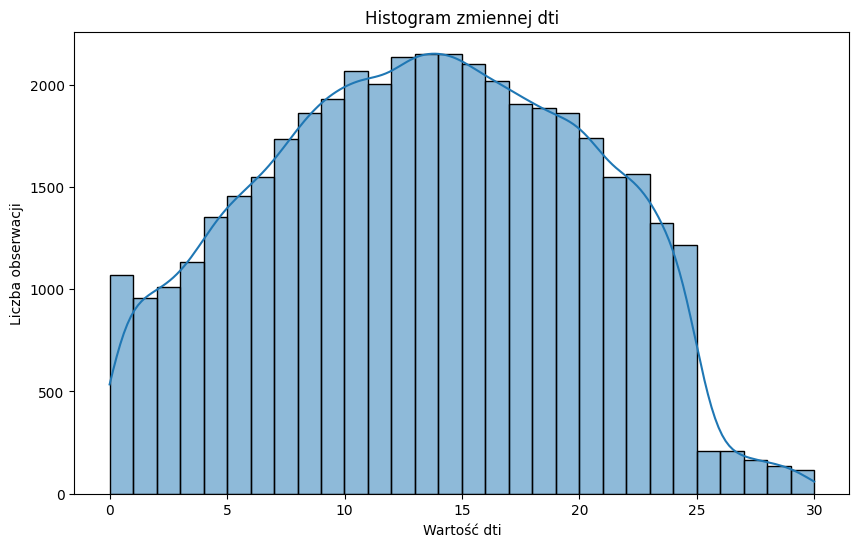

In [44]:
# Wykres histogramu zmiennej 'dti'
plt.figure(figsize=(10, 6))
sns.histplot(df['dti'].dropna(), bins=30, kde=True)
plt.xlabel('Wartość dti')
plt.ylabel('Liczba obserwacji')
plt.title('Histogram zmiennej dti')
plt.show()

In [45]:
from scipy.stats import shapiro

stat, p = shapiro(df['dti'].dropna())

print(f'Statystyka testowa: {stat}')
print(f'P-wartość: {p}')

if p > 0.05:
    print('Brak dowodów na odrzucenie hipotezy o normalności danych.')
else:
    print('Odrzucenie hipotezy o normalności danych.')

Statystyka testowa: 0.9828869104385376
P-wartość: 0.0
Odrzucenie hipotezy o normalności danych.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


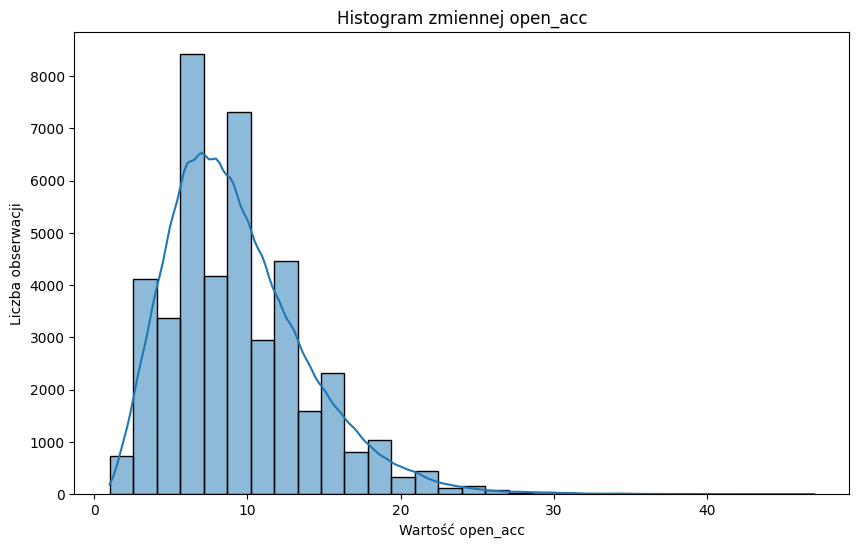

In [46]:
# Wykres histogramu zmiennej "open_acc"
plt.figure(figsize=(10, 6))
sns.histplot(df["open_acc"].dropna(), bins=30, kde=True)
plt.xlabel('Wartość open_acc')
plt.ylabel('Liczba obserwacji')
plt.title('Histogram zmiennej open_acc')
plt.show()